<span style="font-size:24px">
Challenge: Predict <span style="color:Tomato; text-transform: uppercase;">probability of Heart Disease</span> 💔 given patient demographics.</span>

--- 
# 💾 Initialize and Load Data

In [1]:
# Import libraries
import warnings
warnings.filterwarnings("ignore")

# Update libraries
!pip install --upgrade scikit-learn
!pip install --upgrade plotly  ## 5.24.1 -> 6.3.1
!pip install --upgrade seaborn  ##  0.12.2 ->  0.12.3

# data manipulation
import numpy as np
import pandas as pd

# import common libraries and toolkits
from multiprocessing import Pool, cpu_count
import urllib.request
#import sys
#import os

# machine learning libraries
import sklearn as skl
import lightgbm as lgb
import xgboost as xgb
import catboost as catb
import umap

# visualization libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as go

# time management
import optuna
from time import time
from tqdm import tqdm

# other useful libraries
import math 
import itertools
import random

#import pkg_resources
#print("hdbscan:", pkg_resources.get_distribution("hdbscan").version)
#print("sklearn:", skl.__version__)
#print("plotly:", go.__version__)


# reuse my kaggle tabular data functions
url = "https://raw.githubusercontent.com/2awesome-rob/iron_fungi/main/my_kaggle_functions.py"
urllib.request.urlretrieve(url, "my_kaggle_functions.py")
import my_kaggle_functions as mkf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 55.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.8.4 requires fastcore<1.9,>=1.8.0, but you have fastcore 1.11.3 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 65.9 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.24.1
    Uninstalling plotly-5.24.1:
      Successfully uninstalled plotly-5.24.1


2026-02-17 05:46:39.446221: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771307199.630356      18 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771307199.683732      18 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771307200.117781      18 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771307200.117846      18 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771307200.117851      18 computation_placer.cc:177] computation placer alr

In [2]:
# specify path
PATH = "/kaggle/input/playground-series-s6e2/"
print(f"Home path is: {PATH}")

# load data
DEVICE, CORES  = mkf.set_globals(verbose = True)
XY, features, targets, target = mkf.load_tabular_data(PATH)

Home path is: /kaggle/input/playground-series-s6e2/
Using device: cpu
Using 4 CPU cores when multiprocessing
Loaded 630000 training samples of 13 predictive features and 1 target(s) in DataFrame.
Loaded 270000 testing samples in DataFrame.
DataFrame shape: (900000, 15). Ready to explore, engineer, and predict!


---
# 🧭 Exporatory Data Analysis
## 🎯 Target

<class 'pandas.core.series.Series'>
Index: 630000 entries, 0 to 629999
Series name: Heart Disease
Non-Null Count   Dtype 
--------------   ----- 
630000 non-null  object
dtypes: object(1)
memory usage: 9.6+ MB
None
id
0    Presence
1     Absence
2     Absence
3     Absence
4    Presence
Name: Heart Disease, dtype: object
count      630000
unique          2
top       Absence
freq       347546
Name: Heart Disease, dtype: object


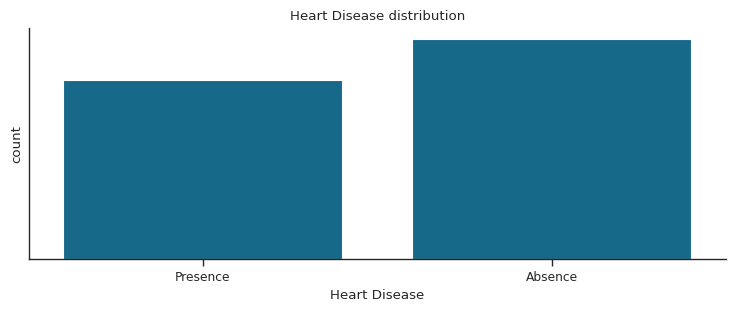

In [3]:
# print target summary
mkf.summarize_data(XY[XY.target_mask.eq(True)], target)

# plot target distribution
mkf.plot_target_eda(XY[XY.target_mask.eq(True)], target,
                    title = f'{target} distribution')

#### 👀 target observations and notes
- target is binary
- Heart Disease: naive <span style="color:Tomato; text-transform: uppercase;">**prior probabliity of 45%** </span>

In [4]:
# target -> boolean
XY[target].replace({'Presence': 1, 'Absence': 0}, inplace=True)

# add labels for plotting
XY, targets = mkf.get_target_labels(XY, target, targets)


---
## 🔬 Features

<class 'pandas.core.frame.DataFrame'>
Index: 630000 entries, 0 to 629999
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   age                      630000 non-null  int64  
 1   sex                      630000 non-null  int64  
 2   chest_pain_type          630000 non-null  int64  
 3   bp                       630000 non-null  int64  
 4   cholesterol              630000 non-null  int64  
 5   fbs_over_120             630000 non-null  int64  
 6   ekg_results              630000 non-null  int64  
 7   max_hr                   630000 non-null  int64  
 8   exercise_angina          630000 non-null  int64  
 9   st_depression            630000 non-null  float64
 10  slope_of_st              630000 non-null  int64  
 11  number_of_vessels_fluro  630000 non-null  int64  
 12  thallium                 630000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 67.3 MB
None
id          

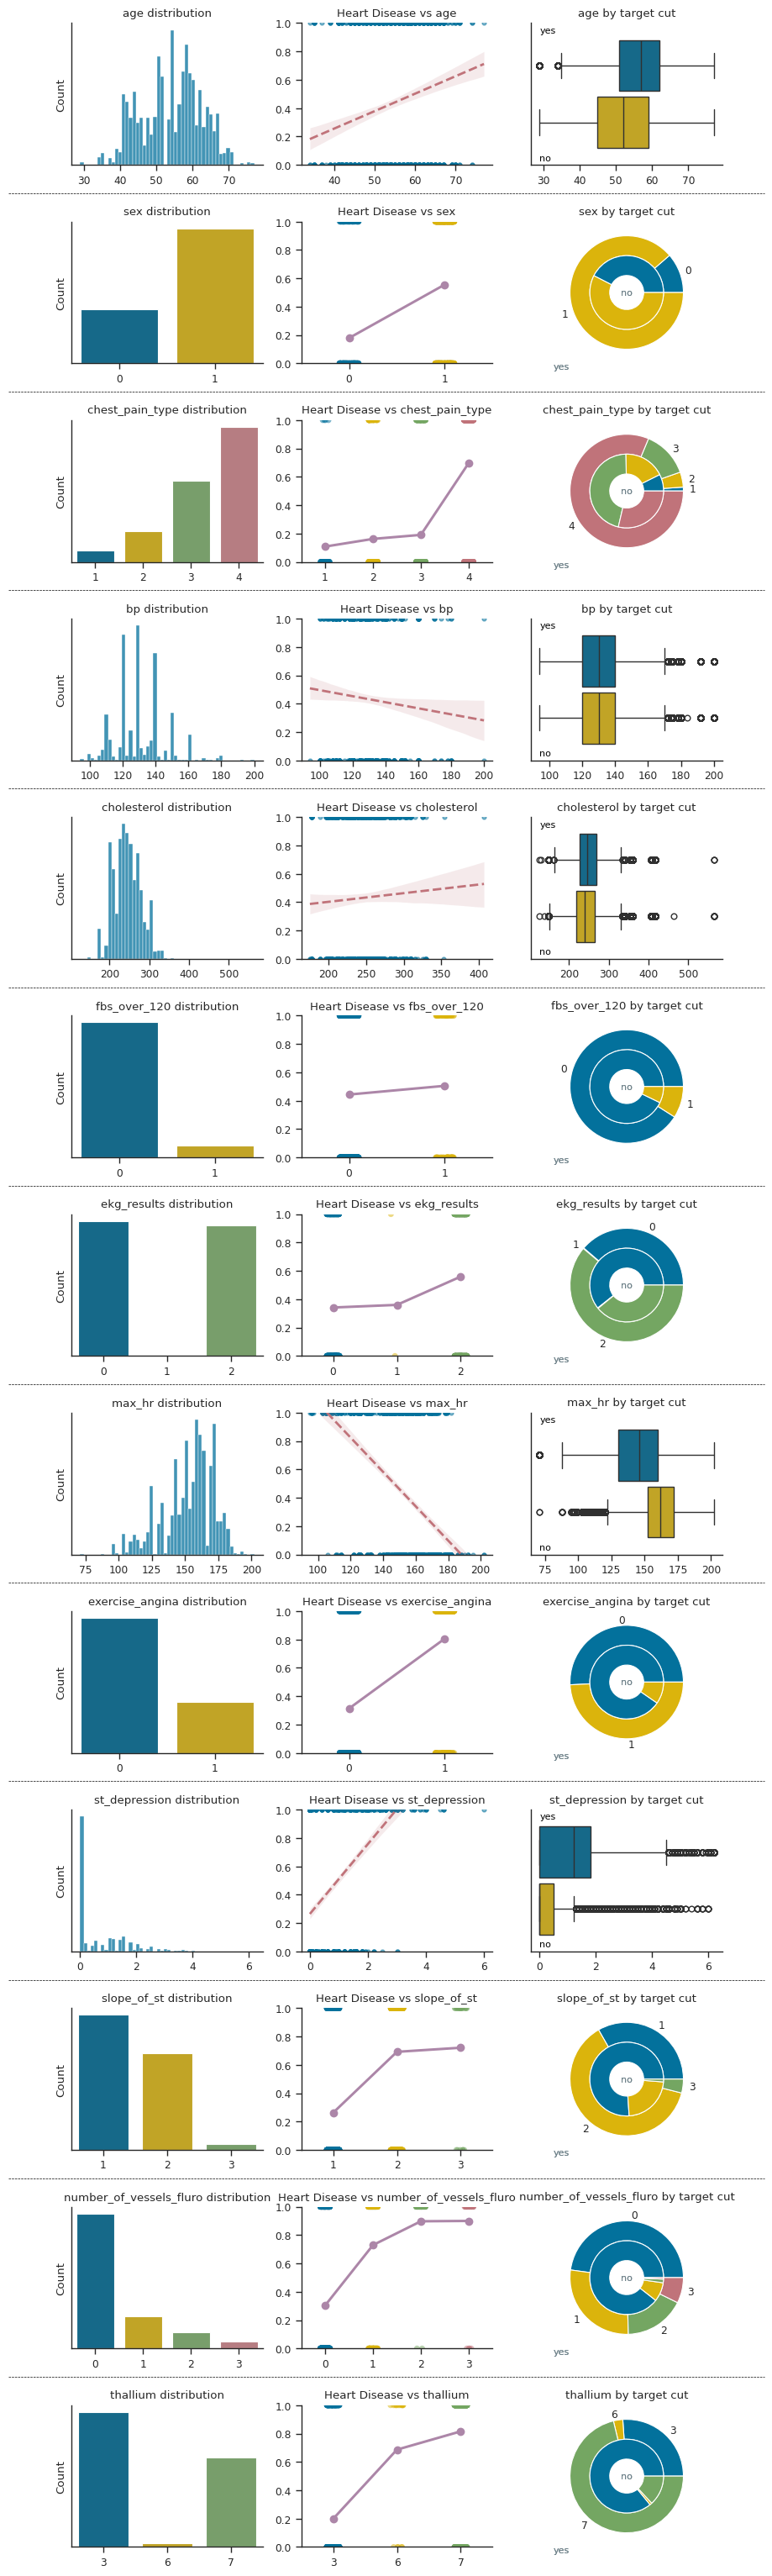

In [5]:
# show feature stats
mkf.summarize_data(XY[XY.target_mask.eq(True)], features)

mkf.plot_features_eda(XY[XY.target_mask.eq(True)], features, 
                      target, 'label', high_label="yes", low_label="no")

In [6]:
bool_features =['sex', 'fbs_over_120', 'exercise_angina']
for f in bool_features:
    XY[f] = XY[f].astype("bool")


cat_features = ['chest_pain_type', 'ekg_results', 'slope_of_st', 'thallium']
for f in cat_features:
    XY[f] = XY[f].astype("category")

#### 👀 Feature Observations and Notes
- 13 predictive features: 5 numeric, 3 boolean, 5 categoricals encoded as ordinal integers
- No missing data

<span style= "color:Tomato; font-size:16px"><strong>
Numeric features:</strong></span>
- age: normal distribution, **strong** predictive power
- bp: left skew distribution, **strong** predictive power
- cholesterol: left skew distribution driven by outliers, **strong** predictive power
- max_hr: right skew distribution, **very strong** predictive power
- st_depression: left skew distribution, **strong** predictive power
- number_of_vessels_fluro: integer count (0 to 3) with **strong** predictive power
 
<span style= "color:Tomato; font-size:16px"><strong>
Boolean features: </strong></span>
- sex: 30/70 split with **strong** predictive power
- fbs_over_120: 90/10 split with **some** predictive power
- exercise_angina: 70/30 split with **strong** predictive power

<span style= "color:Tomato; font-size:16px"><strong>
Categorical features:</strong></span>
- chest_pain_type: 4 values -> encoded in dataset as ordinal with **strong** predictive power
- ekg_results: 3 values -> encoded in dataset as ordinal with **some** predictive power
- slope_of_st: 3 values -> encoded in dataset as ordinal with **strong** predictive power
- thallium: 3 values -> encoded in dataset as ordinal with **some** predictive power

---
## 🔰 Out of the Box Performance

In [7]:
model = lgb.LGBMClassifier(verbose=-1, n_jobs=CORES)

training_features = features
X_train, y_train, X_val,  y_val, X_test, y_test = mkf.split_training_data(
    XY, training_features, target, validation_size = 0.2
)

***  model score:  0.9551  ***
  ***  Top feature is: max_hr  *** 

  Top Features:
max_hr         895
age            342
cholesterol    306
Name: importance, dtype: int32
  Bottom Features:
thallium        90
ekg_results     86
fbs_over_120     7
Name: importance, dtype: int32
Zero importance features: 0 of 13


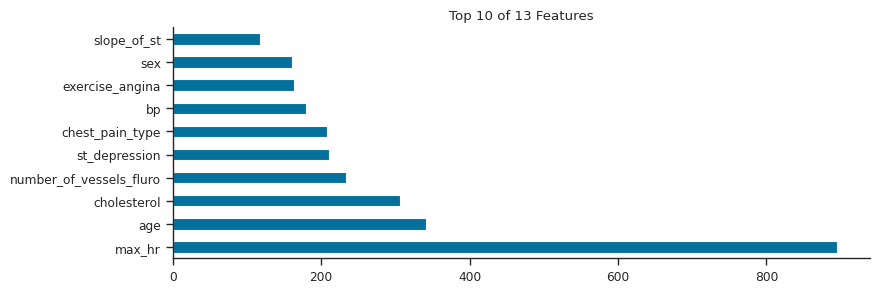

In [8]:
# check feature_importance
feature_importance = mkf.get_feature_importance(
    X_train, X_val, y_train, y_val, task="classification_probability"
)

***  model score:  0.7760  ***


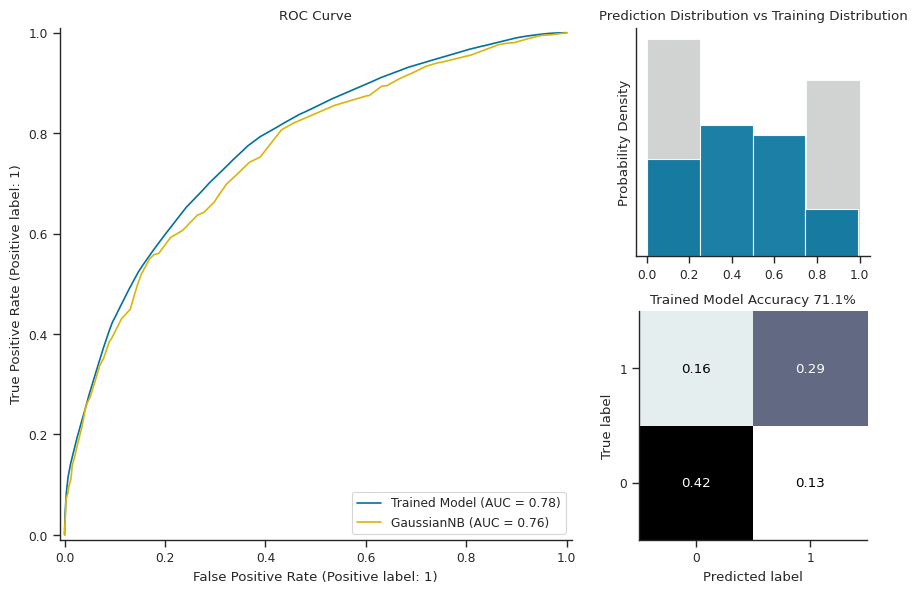

In [9]:
single_feature = feature_importance.index.tolist()[:1]

single_feature_model, _ = mkf.train_and_score_model(
    X_train[single_feature], X_val[single_feature], y_train, y_val, 
    model, task="classification_probability"
)

***  model score:  0.9551  ***


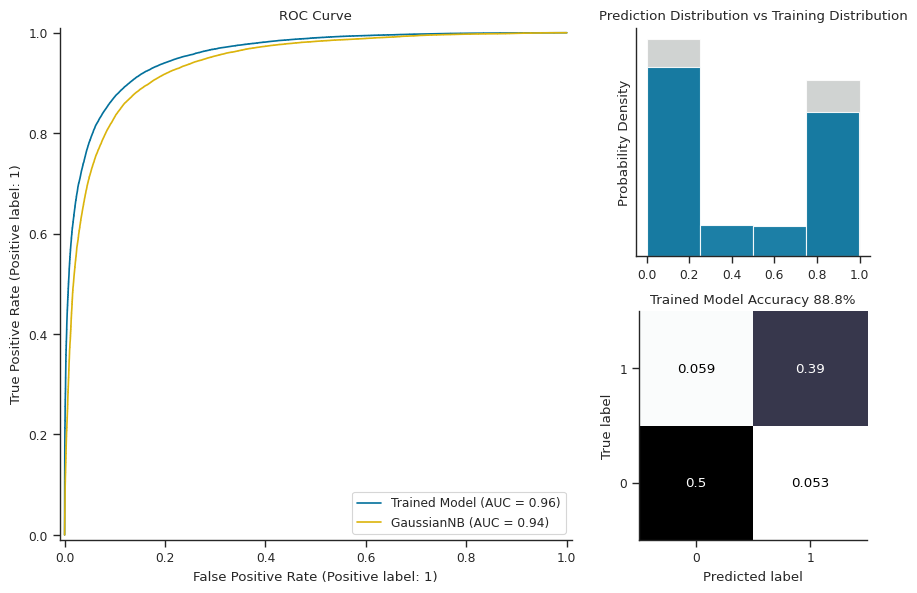

In [10]:
oob_model, _ = mkf.train_and_score_model(
    X_train, X_val, y_train, y_val, 
    model, task="classification_probability"
)

#### 👀 Initial Model Observations and Notes
- Single Feature model is predictive, but poor (AUC = 0.78, Acc = 71%)
- Full Feature model is very good out of the box (AUC 0.96, Acc = 89%)
- Untuned LGBM (AUC = 0.96) slightly outperforms GaussianNB (0.94)
- Type I and Type II errors balanced (5-6% each)
---
# 📐 Feature Engineering
## ➕ Add Features

In [11]:
# add simple feature interactions
training_features = [f for f in features if 
                     XY[f].dtype != "bool"]

XY = mkf.get_feature_interactions(XY, training_features)

# power transform features
training_features = ['age', 'bp', 'cholesterol', 'max_hr']
XY = mkf.get_transformed_features(
    XY, training_features, skl.preprocessing.PowerTransformer()
)

# minmax transform features
training_features = ['st_depression', 'number_of_vessels_fluro']
XY = mkf.get_transformed_features(
    XY, training_features, skl.preprocessing.MinMaxScaler()
)


Creating interaction features: 45pairs [00:04,  9.12pairs/s]
Transforming features: 100%|██████████| 45/45 [00:53<00:00,  1.19s/features]


Added 45 inteaction features


Transforming features: 100%|██████████| 2/2 [00:00<00:00, 152.13features/s]


---
## ➖ Dimension Reduction
### Embeddings

Training embedding function...
Added 32 rbf_ embedding features in 5.58sec
Training embedding function...
Added 16 pca_all_ embedding features in 5.33sec


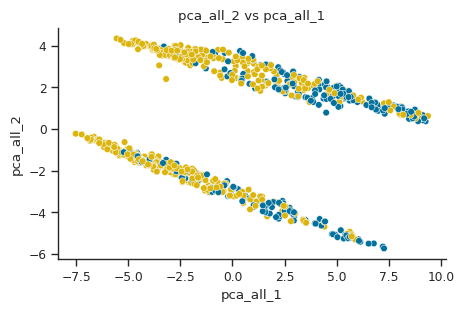

Training embedding function...
Mapping features to embeddings...
Added 16 umap_all_ embedding features in 221.02sec


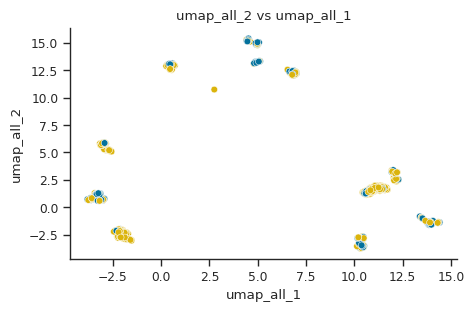

In [12]:
# 'All' training features
training_features = [f for f in XY.columns if f not in targets]

XY = mkf.get_embeddings(XY, training_features, 
    skl.kernel_approximation.RBFSampler(n_components=32), "rbf_",
    verbose=False
)

XY = mkf.get_embeddings(XY, training_features, 
    skl.decomposition.PCA(n_components=16), "pca_all_",
    target=target, verbose=True
)

XY = mkf.get_embeddings(XY, training_features, 
    umap.UMAP(n_components=16), "umap_all_", sample_size=0.1,
    target=target, verbose=True
)

Training embedding function...
Added 8 pca_orig_ embedding features in 0.09sec


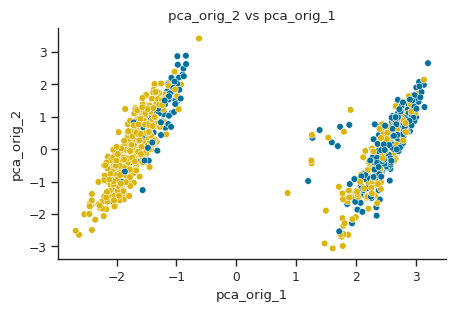

Training embedding function...
Mapping features to embeddings...
Added 8 umap_orig_ embedding features in 174.11sec


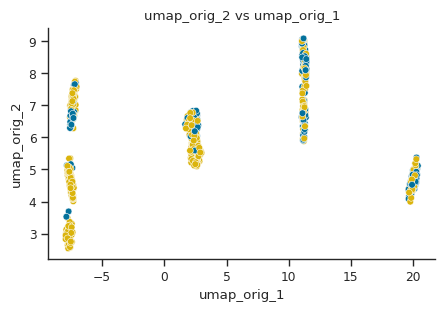

In [13]:
# original features
training_features = [f for f in features if 
                     XY[f].dtype != "bool"]

# get PCA loadings 
XY = mkf.get_embeddings(XY, training_features,
    skl.decomposition.PCA(n_components=8), "pca_orig_",
    target=target, verbose = True
)

# get UMAP loadings 
XY = mkf.get_embeddings(XY, training_features,
    umap.UMAP(n_components=8), "umap_orig_", sample_size=0.1, 
    target=target, verbose = True
)

- UMAP embeddings takes 180-240s (2-3 min) each

### Clusters

Encoding cluster feature 'k_means_umap'
Cluster feature 'k_means_umap' replaced with mean target value by cluster
Added cluster feature 'k_means_umap' with 16 unique values in 2.21sec


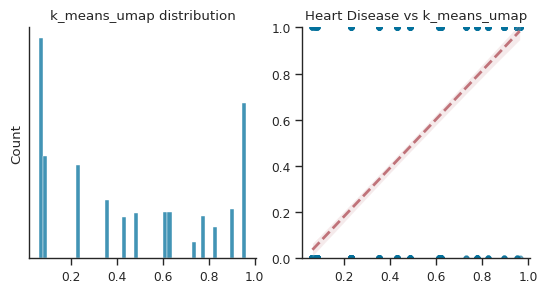

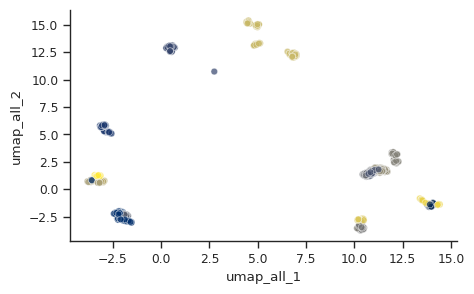

In [14]:
training_features = [f for f in XY.columns if f not in targets and
                     "umap" in f]

XY = mkf.get_clusters(XY, training_features,
    skl.cluster.KMeans(init="k-means++", n_clusters=16, random_state=80085), "k_means_umap", 
    target=target)

Encoding cluster feature 'k_means_pca'
Cluster feature 'k_means_pca' replaced with mean target value by cluster
Added cluster feature 'k_means_pca' with 8 unique values in 1.90sec


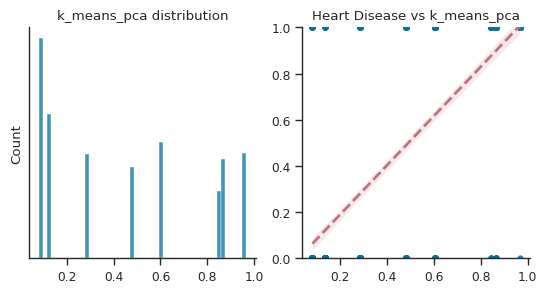

Encoding cluster feature 'dbscan_pca'
Cluster feature 'dbscan_pca' replaced with mean target value by cluster
Added cluster feature 'dbscan_pca' with 65 unique values in 1888.83sec
Cluster feature 'dbscan_pca' identified 27.41% noise


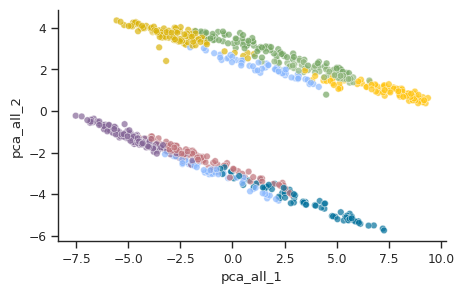

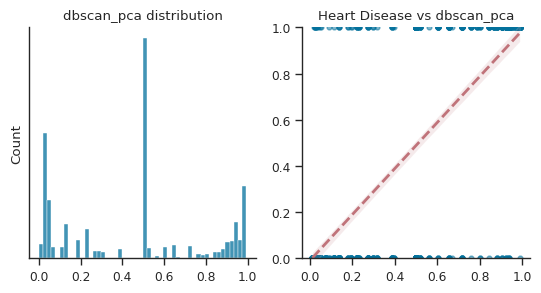

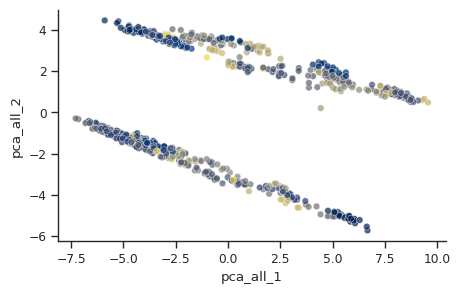

In [15]:
training_features = [f for f in XY.columns if f not in targets and
                     "pca" in f]

XY = mkf.get_clusters(XY, training_features,
    skl.cluster.KMeans(init="k-means++", n_clusters=8, random_state=69),  "k_means_pca",
    target=target)

XY = mkf.get_clusters(XY, training_features,
    skl.cluster.DBSCAN(eps=2, min_samples=199, metric='euclidean', leaf_size=30, n_jobs=CORES), "dbscan_pca", 
    target=target)

- DBSCAN clustering takes about 2200sec (35-40min) for an interesting feature - but it's not impacting overall score

Encoding cluster feature 'k_means_all'
Cluster feature 'k_means_all' replaced with mean target value by cluster
Added cluster feature 'k_means_all' with 22 unique values in 16.76sec


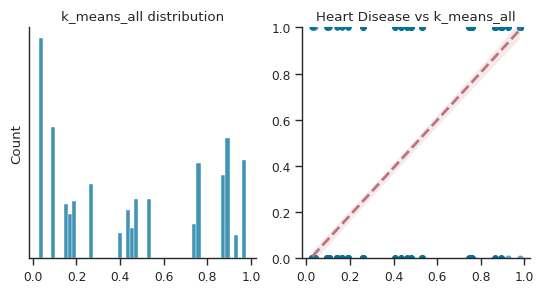

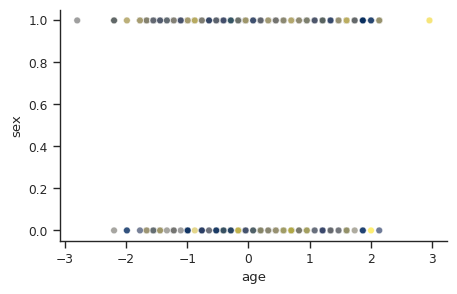

In [16]:
training_features = [f for f in XY.columns if f not in targets and
                    "pca" not in f and
                    "umap" not in f and
                    "k_means" not in f]

XY = mkf.get_clusters(XY, training_features,
    skl.cluster.KMeans(init="k-means++", n_clusters=22, random_state=69),  "k_means_all",
    target=target)

In [17]:
training_features = [f for f in XY.columns if f not in targets and 
                     ("k_means" in f or "dbscan" in f) and
                     "noise" not in f]

if len(training_features) > 1:
    for combination in itertools.combinations(training_features, 2):
        XY["_and_".join(combination)] = XY[list(combination)].sum(axis=1) * 0.5

if len(training_features) > 2:
    for combination in itertools.combinations(training_features, 3):
        XY["_and_".join(combination)] = XY[list(combination)].sum(axis=1) * 0.333
    

---
## 🟰 Updated Performance Evaluation

***  model score:  0.9546  ***
  ***  Top feature is: max_hr  *** 



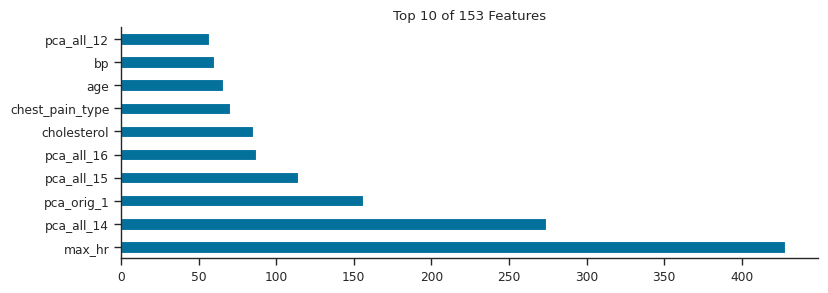

In [18]:
training_features = [f for f in XY.columns.tolist() if f not in targets]

X_train, y_train, X_val,  y_val, X_test, y_test = mkf.split_training_data(
    XY, training_features, target, validation_size = 0.2)

feature_importance = mkf.get_feature_importance(
    X_train, X_val, y_train, y_val, verbose=False, task = "classification_probability")

***  model score:  0.9548  ***


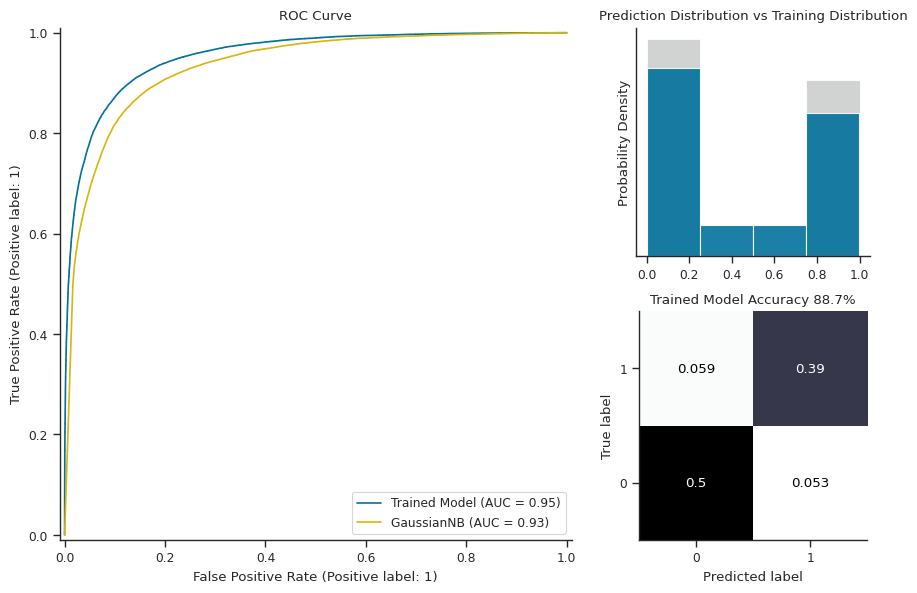

In [19]:
training_features = [f for f in feature_importance.index.tolist() if feature_importance[f] > 15]
X_train, y_train, X_val, y_val, _, _ = mkf.split_training_data(
    XY, training_features, target, validation_size=0.2)

trained_model, _ = mkf.train_and_score_model(
    X_train, X_val, y_train, y_val, model, task = "classification_probability")

#### 👀 Feature Engineering Observations and Notes
- No real change in model performance (AUC 0.96, Acc = 89%)
- pca projection results in a more predicitive single features (pca1, AUC 0.93, Acc 86%)
- [ ] TODO: Examine "hard to predict" features -> e.g. clusters with 0.3 < p < 0.7
---

# 🏃‍♂️ Training and Evaluation
## 👯‍♀️ Model Selection

- base_models -> model classes
- models -> base models with hyperparameters
- training_features -> list of training features for each model class


In [20]:
important_features = [f for f in feature_importance.index.tolist() if feature_importance[f] > 1]
base_models = {
    'lr' : skl.linear_model.LogisticRegression, 
    'hgb' : skl.ensemble.HistGradientBoostingClassifier,
    'lgb' : lgb.LGBMClassifier,
    'xgb' : xgb.XGBClassifier, 
    'catb' : catb.CatBoostClassifier
}

params = {
    'lr' : {'C': 0.6, 'max_iter': 267, 'solver': 'sag'}, 
    'hgb' : {'max_iter': 1000, 'learning_rate': 0.038, 'max_leaf_nodes': 24, 'min_samples_leaf': 24, 'l2_regularization': 0.008, 'early_stopping': True}
}

models, training_features = mkf.get_ready_models(XY, important_features, target, 
    base_models, task='classification_probability', direction='maximize', hyper_params=params,
    n_features=3, n_trials=22, CORES=CORES, DEVICE=DEVICE, verbose=False
)

Studying lgb hyperparameters


[I 2026-02-17 06:28:19,685] A new study created in memory with name: no-name-fe219675-0cda-4999-9e9b-12ddb1a3fdfe
[I 2026-02-17 06:28:22,940] Trial 0 finished with value: 0.8806787337612134 and parameters: {'n_estimators': 272, 'learning_rate': 0.00865897944029759, 'num_leaves': 44, 'reg_alpha': 0.006404904466100732, 'reg_lambda': 0.0316753925165945, 'n_jobs': 4, 'verbose': -1}. Best is trial 0 with value: 0.8806787337612134.
[I 2026-02-17 06:28:27,801] Trial 1 finished with value: 0.8794925894535812 and parameters: {'n_estimators': 304, 'learning_rate': 0.05589694020296138, 'num_leaves': 84, 'reg_alpha': 0.01419790291417404, 'reg_lambda': 0.010399428597957415, 'n_jobs': 4, 'verbose': -1}. Best is trial 0 with value: 0.8806787337612134.
[I 2026-02-17 06:28:29,768] Trial 2 finished with value: 0.8715019461603437 and parameters: {'n_estimators': 256, 'learning_rate': 0.3772513490064275, 'num_leaves': 28, 'reg_alpha': 0.005072053253956599, 'reg_lambda': 0.012890374596998131, 'n_jobs': 4, 

Best lgb params: {'n_estimators': 176, 'learning_rate': 0.02606849341066214, 'num_leaves': 28, 'reg_alpha': 0.012221897934510846, 'reg_lambda': 0.06776541906616286, 'n_jobs': 4, 'verbose': -1}
Studying xgb hyperparameters


[I 2026-02-17 06:29:22,195] A new study created in memory with name: no-name-c86dabb9-dd04-471c-bff8-339953d9507f
[I 2026-02-17 06:29:26,915] Trial 0 finished with value: 0.8734762483923507 and parameters: {'n_estimators': 544, 'learning_rate': 0.28015583645992986, 'max_leaves': 140, 'max_bins': 92, 'reg_alpha': 0.0029830736028313024, 'reg_lambda': 0.04020600808966805, 'gamma': 0.04090521524349472, 'device': 'cpu', 'verbosity': 0, 'enable_categorical': True}. Best is trial 0 with value: 0.8734762483923507.
[I 2026-02-17 06:29:29,698] Trial 1 finished with value: 0.8811992862278953 and parameters: {'n_estimators': 272, 'learning_rate': 0.05614668605732643, 'max_leaves': 128, 'max_bins': 180, 'reg_alpha': 0.016557803625729565, 'reg_lambda': 0.057694359801895335, 'gamma': 0.0145223062444137, 'device': 'cpu', 'verbosity': 0, 'enable_categorical': True}. Best is trial 1 with value: 0.8811992862278953.
[I 2026-02-17 06:29:33,446] Trial 2 finished with value: 0.873946468415653 and parameters:

Best xgb params: {'n_estimators': 592, 'learning_rate': 0.01491259279540924, 'max_leaves': 20, 'max_bins': 124, 'reg_alpha': 0.02461138274936374, 'reg_lambda': 0.0010644401053296632, 'gamma': 0.009831128215979104, 'device': 'cpu', 'verbosity': 0, 'enable_categorical': True}
Studying catb hyperparameters


[I 2026-02-17 06:31:11,222] A new study created in memory with name: no-name-01cb855c-f798-49cc-9b8d-685c88b91e04
[I 2026-02-17 06:31:13,840] Trial 0 finished with value: 0.8816278764657458 and parameters: {'n_estimators': 208, 'learning_rate': 0.034135216673603676, 'l2_leaf_reg': 0.0010619220479368776, 'model_size_reg': 0.10024403527995829, 'task_type': 'CPU', 'cat_features': [], 'verbose': 0}. Best is trial 0 with value: 0.8816278764657458.
[I 2026-02-17 06:31:17,394] Trial 1 finished with value: 0.8736965696039194 and parameters: {'n_estimators': 288, 'learning_rate': 0.00666406830576767, 'l2_leaf_reg': 0.0001978607784371972, 'model_size_reg': 0.0015183612534045096, 'task_type': 'CPU', 'cat_features': [], 'verbose': 0}. Best is trial 0 with value: 0.8816278764657458.
[I 2026-02-17 06:31:20,758] Trial 2 finished with value: 0.8791168300499164 and parameters: {'n_estimators': 288, 'learning_rate': 0.12129977477226053, 'l2_leaf_reg': 0.08036108227274232, 'model_size_reg': 0.00113372023

Best catb params: {'n_estimators': 208, 'learning_rate': 0.034135216673603676, 'l2_leaf_reg': 0.0010619220479368776, 'model_size_reg': 0.10024403527995829, 'task_type': 'CPU', 'cat_features': [], 'verbose': 0}


## 🏋️‍♂️ Model Training

#### For 9 folds:
- 'lr'   : 35s  / fold 
- 'hgb'  : 130s / fold
- 'lgb'  : 12s  / fold
- 'xgb'  : 30s  / fold
- 'catb' : 30s  / fold

Training 5 Models
Training Model: lr


training models: 9folds [21:32, 143.57s/folds]


Score:  0.9457

***  model lr score:  0.9457  ***


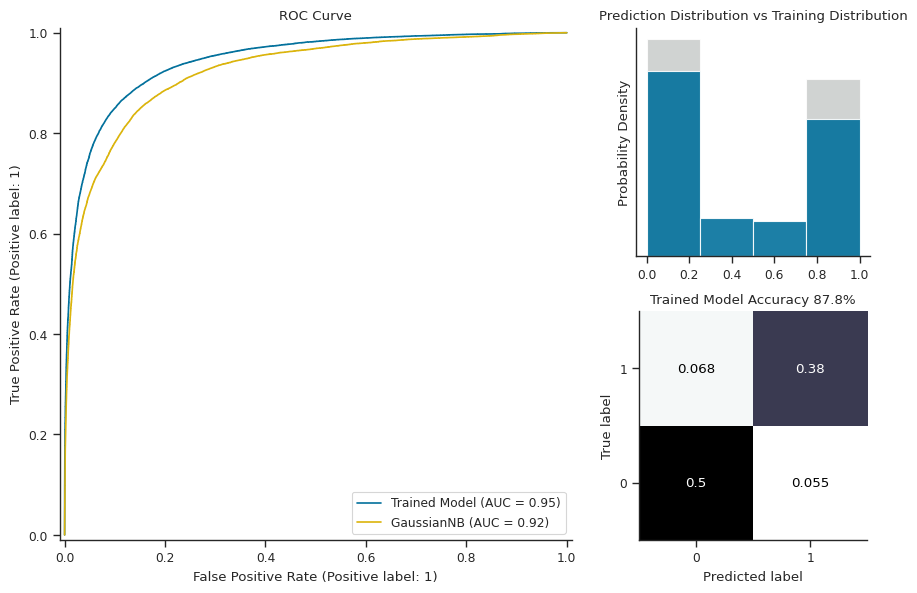

Training Model: hgb


training models: 9folds [06:08, 40.94s/folds]


Score:  0.9543

***  model hgb score:  0.9543  ***


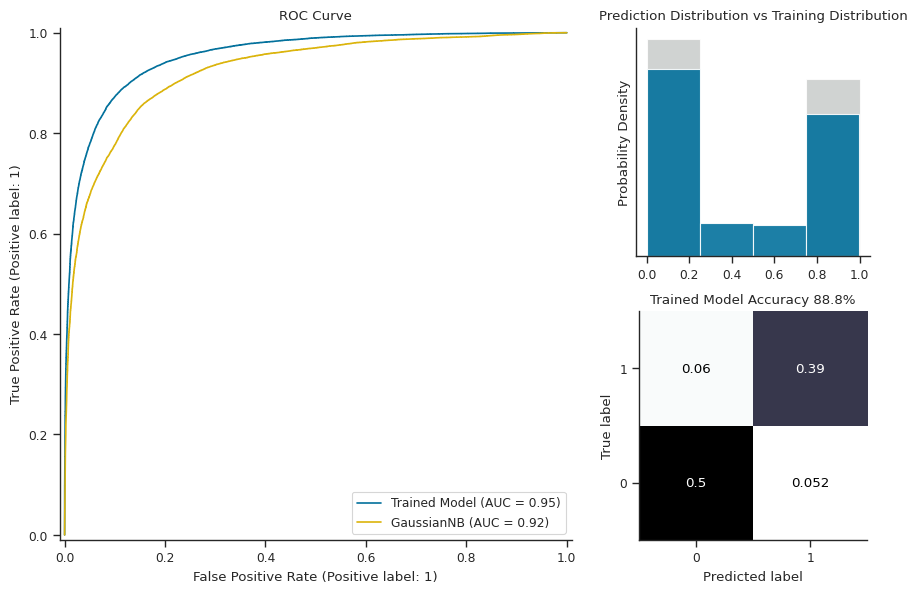

Training Model: lgb


training models: 9folds [02:29, 16.56s/folds]


Score:  0.9527

***  model lgb score:  0.9527  ***


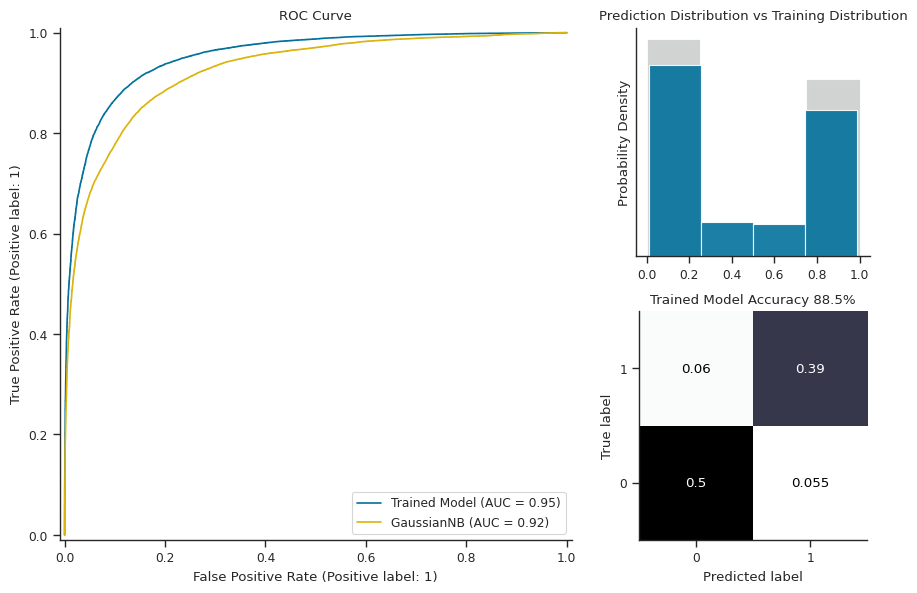

Training Model: xgb


training models: 9folds [05:38, 37.57s/folds]


Score:  0.9527

***  model xgb score:  0.9527  ***


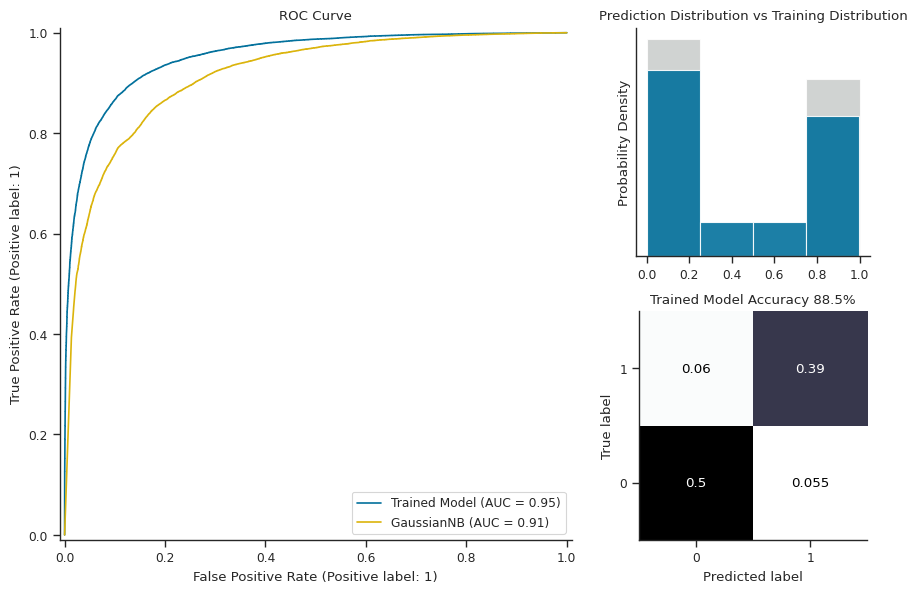

Training Model: catb


training models: 9folds [03:06, 20.68s/folds]


Score:  0.9523

***  model catb score:  0.9523  ***


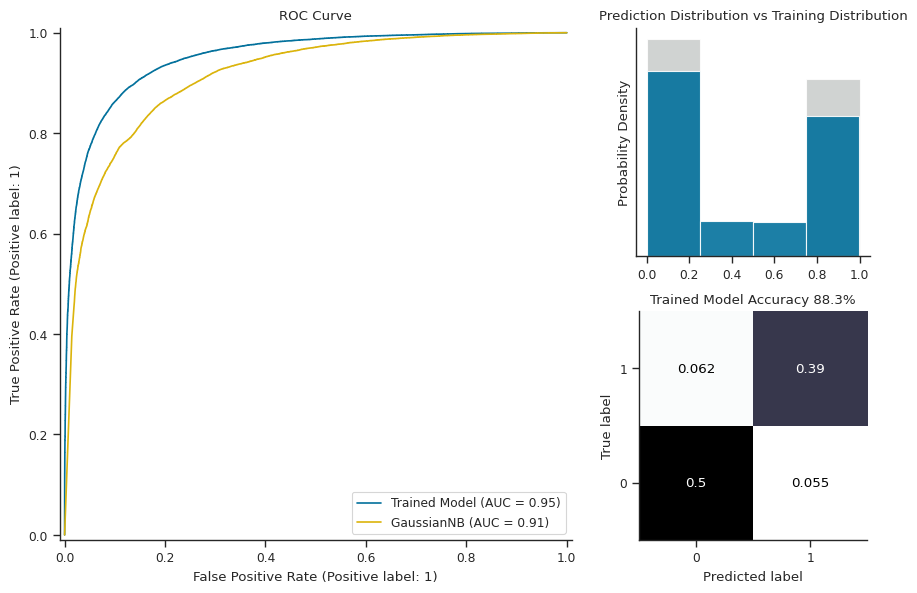

In [21]:
trained_models, stacking_model = mkf.cv_train_models(XY, training_features, target,
    models, task='classification_probability', folds=9
    )

---
# 🔮 Predict & Submit

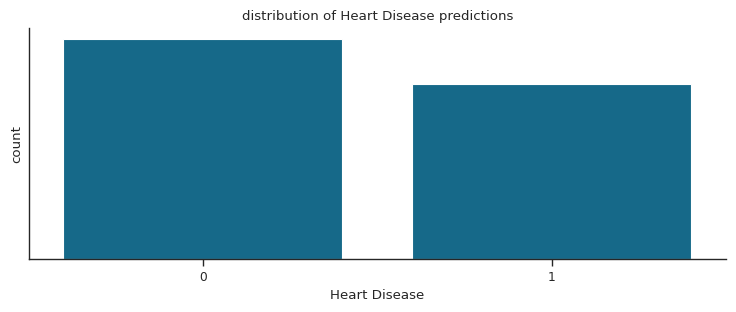

====== save success ====== 

Predicted target mean: 0.4422 +/- 0.4967


In [22]:
predictions = mkf.submit_cv_predict(X_test, y_test, training_features, target, 
                      trained_models, task='classification_probability',
                      meta_model=stacking_model,
                      path=PATH, verbose=True)